**알츠하이머 MRI 질병 분류**

이 노트북은 PyTorch를 처음 사용하는 것이며, 보통은 TensorFlow로 작업합니다. 따라서 이는 딥러닝이나 PyTorch를 처음 시작하는 분들에게 유용한 자료가 될 것입니다.

이 작업의 목표는 환자의 MRI 스캔을 사용하여 환자가 알츠하이머병을 앓고 있는지, 그리고 그 정도는 어떤지를 분류하는 것입니다. 총 네 가지 클래스 중 하나를 예측합니다:

1. 비치매 (Non demented)
2. 매우 경미한 치매 (Very mildly demented)
3. 경미한 치매 (Mildly demented)
4. 중간 정도의 치매 (Moderately demented)


In [2]:
import torch
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import time
import os
import PIL
from PIL import Image
cudnn.benchmark = True

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [11]:
BASE_DIR = "Alzheimer MRI Disease Classification Dataset"
disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

## 데이터 읽기

데이터는 Parquet 파일 형식으로 저장되어 있습니다. Pandas를 사용하여 간단히 읽을 수 있습니다.

In [16]:
df = pd.read_parquet(f"train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow")
df.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [21]:
test = pd.read_parquet(f"test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")

이 데이터는 특이한 형식으로 되어 있습니다. 단순히 이미지와 레이블을 포함하는 딕셔너리입니다. 우리가 가장 먼저 해야 할 것은 이러한 암호 같은 "이미지"를 픽셀 강도를 나타내는 NumPy 배열로 변환하는 것입니다. 우리는 MRI가 그레이스케일이라고 가정합니다.

In [24]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

In [26]:
df['img_arr'] = df['image'].apply(dict_to_image)
df.drop("image", axis=1, inplace=True)
df.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [28]:
test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)

이제 변환이 완료되었으므로 몇 개의 이미지를 플로팅하여 모든 것이 올바르게 작동했는지 확인할 수 있습니다. 또한, 나중에 모델을 올바르게 설정하기 위해 이미지의 형태를 이해할 필요가 있습니다.

## 데이터 탐색

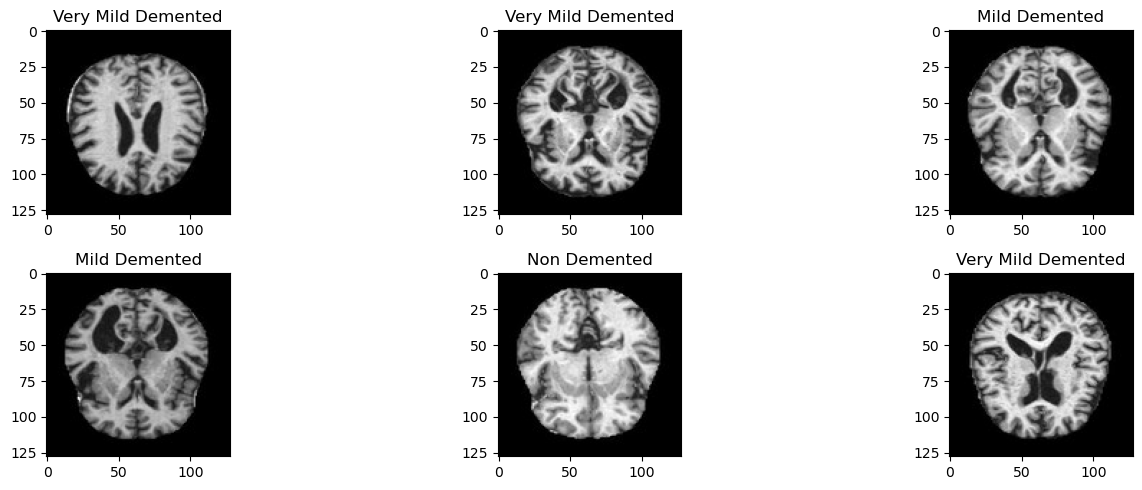

In [71]:
# 이미지를 실제로 렌더링할 수 있는지 확인하고, 그것이 합리적으로 보이는지 확인합니다.

fig, ax = plt.subplots(2, 3, figsize=(15, 5))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(df))
    axes.imshow(df.iloc[rand]['img_arr'], cmap="gray")
    axes.set_title(disease_label_from_category[df.iloc[rand]['label']])
plt.tight_layout()
plt.show()

전처리가 완료됐고 이제 모델 선택을 더 효과적으로 조정할 수 있도록 훈련 데이터를 좀 더 조사해 봅니다.

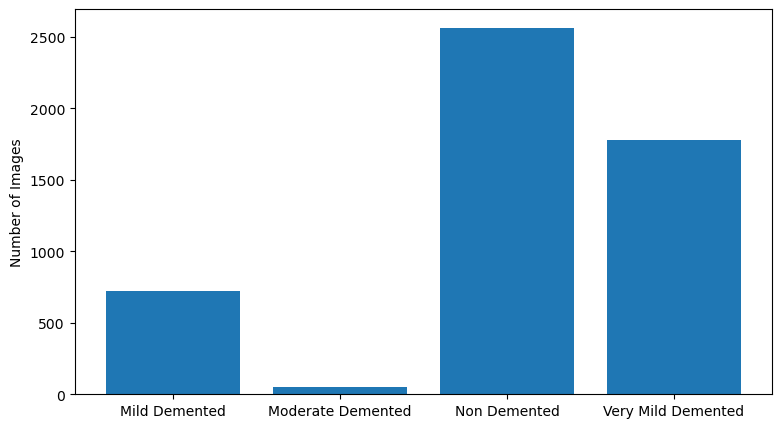

Total samples in training data = 5120


In [33]:
plt.figure(figsize=(9, 5))
plt.bar(np.arange(0, 4, 1), df['label'].value_counts().sort_index())
plt.ylabel("Number of Images")
plt.xticks(np.arange(0, 4, 1), labels=[disease_label_from_category[i] for i in range(4)])
plt.show()
print(f"Total samples in training data = {len(df)}")

이 플롯에서 볼 수 있는 것은 데이터셋에 "중간" 심각도의 사례가 거의 없다는 것입니다. 따라서 모델이 이러한 사례를 식별하는 데 가장 약할 것으로 예상됩니다. 이는 학습할 수 있는 데이터가 매우 적기 때문입니다.

또한 데이터셋에 약 5000개의 이미지가 있다는 점도 확인할 수 있습니다. 이는 자체적으로 상당한 양이지만, 데이터 증강을 활용하여 통계를 향상시킬 수 있습니다! 이는 경미한 및 중간 정도의 치매 환자의 MRI에 매우 유용할 것으로 보이며, 해당 스캔은 훨씬 적습니다.

In [35]:
N_CLASSES = df['label'].nunique()

**기준선: 데이터 증강 없이 기본 CNN 사용하기**
PyTorch의 Dataset 및 DataLoader 객체를 사용하여 데이터를 처리하고 모델에 입력합니다. 데이터셋을 살펴보려면 제공된 세 가지 메서드를 구현하면 됩니다. 그중 __getitem__이 가장 중요합니다!

In [37]:
# Use a torch dataset/dataloader to handle feeding our data in the model
class ImageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]["img_arr"] # Get the label from the df
        label = self.dataframe.iloc[idx]["label"] # Get the img numpy array from the df
        # The CNN requires we add a channel dimension i.e. (128, 128) -> (1, 128, 128)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [39]:
class BaselineCNN(nn.Module):
    # Basic CNN using 2D convolutional layers, some max pooling and
    # a single batch normalisation layer to counter overfitting. We used a linear (dense)
    # layer as the output with the output shape being the number of classes
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.out = nn.Linear(128, N_CLASSES)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

In [41]:
# Hyperparameters, I did a few training iterations and found these to be good
learning_rate = 0.001
NEPOCHS = 10
batch_size = 32

In [43]:
# Create dataset and dataloader
train_dataset = ImageDataset(df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [45]:
def train_model(model, loader, optimizer, num_epochs=NEPOCHS):
    # Initialize model, loss function, and optimizer
    criterion = nn.CrossEntropyLoss()

    # Training loop
    train_losses = []
    for epoch in tqdm.tqdm(range(num_epochs), total=num_epochs):
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        epoch_loss = running_loss / len(loader)
        train_losses.append(epoch_loss)

    print('Finished Training')
    return model, train_losses

In [47]:
model = BaselineCNN().to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
model, train_losses = train_model(model, train_loader, optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [14:02<00:00, 84.24s/it]

Finished Training


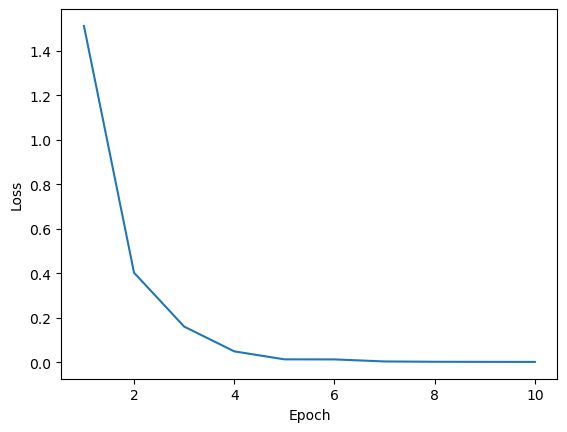

In [50]:
plt.plot(np.arange(1, 11), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [52]:
def predict(m, dl, device):
    m.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():  # Disable gradient computation for inference
        for images, labels in dl:
            images = images.to(device)
            outputs = m(images)
            _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels

def result_summary(predictions, true_labels):
    # Accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy: {accuracy:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predictions)
    print('Confusion Matrix:')
    print(conf_matrix)

    # Precision, Recall, F1 Score
    #class_report = classification_report(true_labels, predictions, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
    #print('Classification Report:')
    #print(class_report)

In [54]:
# Lets display some basic summary statistics to see how we did
# Note: this is dreadful practice to evaluate on the training data but this won't be our
# final model and is just for demonstration purposes!
predictions, true_labels = predict(model, train_loader, device)
result_summary(predictions, true_labels)

Accuracy: 1.0000
Confusion Matrix:
[[ 724    0    0    0]
 [   0   49    0    0]
 [   0    0 2566    0]
 [   0    0    0 1781]]


훈련에서 100% 정확도를 기록했다면, 상당히 과적합(overfitting)되었을 가능성이 높습니다.

In [57]:
# Run the same report on the test data
test_dataset = ImageDataset(test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
predictions_test, test_labels = predict(model, test_loader, device)

result_summary(predictions_test, test_labels)

Accuracy: 0.9758
Confusion Matrix:
[[159   0   8   5]
 [  0  13   0   2]
 [  0   0 630   4]
 [  0   0  12 447]]


So clearly we have overtrained a little, but amazingly our test data also shows an excellent accuracy of 97%! Let us now see if we can improve on this further using more advanced model architectures and techniques.

## Improvement 1: Image Augmentation
In PyTorch this works be applying some random set of transformations at each step (epoch) of the training so your training dataset is the same length, just what the model sees each time is slightly different, hopefully this can help to make the model more general.

In [61]:
# Use a torch dataset/dataloader to handle feeding our data in the model
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]["img_arr"]
        label = self.dataframe.iloc[idx]["label"]
        
        if self.transform:
            image = image.astype(np.uint8)  
            image = self.transform(image)
        
        label = torch.tensor(label, dtype=torch.long)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
            
        return image, label

Here I define the augmentations (transforms) that will be applied during the training pipeline. These are somewhat arbitrary currently because I just want to see if the transforms work - and this is my first time using PyTorch.

The benefit of transformations is it can help our model to become rotationally and spatially invariant i.e. if a future MRI scan is taken at a different angle or with a slightly worse imaging technique our model should generalise better.

In [64]:
transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.3), # Horizontally flip with 30% probability
    v2.RandomVerticalFlip(p=0.3), # Vertical flip with 30% probability
    v2.GaussianBlur(kernel_size=3), # Blur the images using a Gaussian kernel
    v2.RandomRotation(degrees=(-45, 45)), # Randomly rotate the images 
    v2.ToDtype(torch.float32, scale=True), # Upated version of ToTensor
    v2.Normalize(mean=[0.485], std=[0.229]), # Only 1 channel in the image
])

In [66]:
train_dataset = ImageDataset(df, transforms) # Needed as we changed the defn of ImageDataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [68]:
# The only thing I have changed is adding transforms (+5 epochs of train time)
model_aug = BaselineCNN().to(device)
optimizer = optim.AdamW(model_aug.parameters(), lr=learning_rate)
model_aug, train_losses_aug = train_model(model_aug, train_loader, optimizer, num_epochs=15)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [22:34<00:00, 90.31s/it]

Finished Training


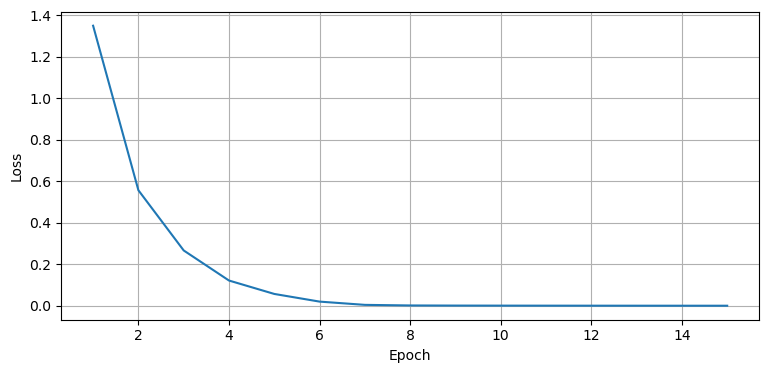

In [79]:
plt.figure(figsize=(9,4))
plt.plot(np.arange(1, 15+1), train_losses_aug)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [81]:
# Do not apply augmentation when generating predictions for evaluation of model performance
train_dataset_notf = ImageDataset(df, None)
train_loader_notf = DataLoader(train_dataset_notf, batch_size=batch_size, shuffle=True)

train_predictions, train_labels = predict(model_aug, train_loader_notf, device)
test_predictions, test_labels = predict(model_aug, test_loader, device)

In [83]:
result_summary(train_predictions, train_labels)

Accuracy: 1.0000
Confusion Matrix:
[[ 724    0    0    0]
 [   0   49    0    0]
 [   0    0 2566    0]
 [   0    0    0 1781]]


In [85]:
result_summary(test_predictions, test_labels)

Accuracy: 0.9766
Confusion Matrix:
[[160   0   8   4]
 [  0  14   0   1]
 [  0   0 631   3]
 [  1   0  13 445]]


그래서 0.3% 개선이 이루어졌습니다. 사실상 개선할 여지가 거의 없기 때문에 이는 큰 의미가 없습니다. 여전히 과적합하고 있으므로, 모델 아키텍처를 살펴보고 더 나은 성능을 낼 수 있는지 확인.

**개선 2: 전이 학습**

참고: ResNet34, DenseNet, VGG16을 사용하여 전이 학습을 시도했지만, 모델을 고정하고 마지막 층만 조정했을 때 80% 이하의 정확도를 기록했습니다. 따라서 전이 학습이 이 작업에 잘 작동하지 않는 것이 분명합니다. 이는 이 모델들이 RGB 이미지로 훈련되었고, 우리의 이미지는 그레이스케일이기 때문일 수 있습니다. 이 문제를 해결하기 위해 첫 번째 채널을 세 개의 깊이로 복제

In [91]:
# I've kept the cell here in case it is a useful reference for someone later
"""
model_tf = models.resnet34(weights='IMAGENET1K_V1')

for param in model_tf.parameters(): # Freeze all but the last layer of the network
    param.requires_grad = False

num_ftrs = model_tf.fc.in_features
model_tf.fc = nn.Linear(num_ftrs, N_CLASSES)
model_tf = model_tf.to(device)

# Note ResNet needs 3 channels! Our grayscale image only has 3, let's paste them
# to make the image "RGB" (duplicate grayscale channel 3 times)
class GrayscaleToRGB(object):
    def __call__(self, image):
        return np.array(Image.fromarray(image).convert("RGB"))

transformsRGB = v2.Compose([
    GrayscaleToRGB(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.GaussianBlur(kernel_size=3),
    v2.RandomRotation(degrees=(-45, 45)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229]), 
])

train_dataset_rgb = ImageDataset(df, transformsRGB, add_dimension=False)
train_loader_rgb = DataLoader(train_dataset_rgb, batch_size=batch_size, shuffle=True) 

optimizer = optim.AdamW(model_tf.fc.parameters(), lr=learning_rate) # todo: Add momentum?
model3, train_losses3 = train_model(model_tf, train_loader_rgb, optimizer, num_epochs=20)

plt.plot(np.arange(1, 20+1), train_losses3)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
"""

'\nmodel_tf = models.resnet34(weights=\'IMAGENET1K_V1\')\n\nfor param in model_tf.parameters(): # Freeze all but the last layer of the network\n    param.requires_grad = False\n\nnum_ftrs = model_tf.fc.in_features\nmodel_tf.fc = nn.Linear(num_ftrs, N_CLASSES)\nmodel_tf = model_tf.to(device)\n\n# Note ResNet needs 3 channels! Our grayscale image only has 3, let\'s paste them\n# to make the image "RGB" (duplicate grayscale channel 3 times)\nclass GrayscaleToRGB(object):\n    def __call__(self, image):\n        return np.array(Image.fromarray(image).convert("RGB"))\n\ntransformsRGB = v2.Compose([\n    GrayscaleToRGB(),\n    v2.RandomHorizontalFlip(p=0.5),\n    v2.RandomVerticalFlip(p=0.5),\n    v2.GaussianBlur(kernel_size=3),\n    v2.RandomRotation(degrees=(-45, 45)),\n    v2.ToDtype(torch.float32, scale=True),\n    v2.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229]), \n])\n\ntrain_dataset_rgb = ImageDataset(df, transformsRGB, add_dimension=False)\ntrain_loader_rgb = DataL

In [93]:
# When we make predictions we now need to add the dummy dimensions back on
"""
eval_transforms = transformsRGB = v2.Compose([
    GrayscaleToRGB()
])

train_data_eval = ImageDataset(df, eval_transforms, add_dimension=False)
train_load_eval = DataLoader(train_data_eval, batch_size=batch_size, shuffle=True)
val_data_eval = ImageDataset(val, eval_transforms, add_dimension=False)
val_load_eval = DataLoader(val_data_eval, batch_size=batch_size, shuffle=True)

train_predictions, train_labels = predict(model3, train_load_eval, device)
val_predictions, val_labels = predict(model3, val_load_eval, device)

result_summary(train_predictions, train_labels)
result_summary(val_predictions, val_labels)
"""

'\neval_transforms = transformsRGB = v2.Compose([\n    GrayscaleToRGB()\n])\n\ntrain_data_eval = ImageDataset(df, eval_transforms, add_dimension=False)\ntrain_load_eval = DataLoader(train_data_eval, batch_size=batch_size, shuffle=True)\nval_data_eval = ImageDataset(val, eval_transforms, add_dimension=False)\nval_load_eval = DataLoader(val_data_eval, batch_size=batch_size, shuffle=True)\n\ntrain_predictions, train_labels = predict(model3, train_load_eval, device)\nval_predictions, val_labels = predict(model3, val_load_eval, device)\n\nresult_summary(train_predictions, train_labels)\nresult_summary(val_predictions, val_labels)\n'

전이 학습이 안됨 RGB문제로 확인

## 개선 3: 개선된 모델 아키텍처 및 학습률 스케줄링

학습률 스케줄링은 도움이 되지 않았습니다. 사실, 성능을 더 악화시켰습니다!

In [96]:
class TunedCNN(nn.Module):
    def __init__(self):
        super(TunedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.drop1 = nn.Dropout(p=0.2)
        self.out = nn.Linear(128, N_CLASSES)
        
    def forward(self, x):
        x = F.mish(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.mish(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        leaky = nn.LeakyReLU(0.01)
        x = leaky(x)
        x = self.drop1(x)
        x = self.out(x)
        return x

In [98]:
model_tune = TunedCNN().to(device)
optimizer = optim.AdamW(model_tune.parameters(), lr=learning_rate)
model_tune, train_losses_tune = train_model(model_tune, train_loader, optimizer, num_epochs=20)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [41:41<00:00, 125.08s/it]

Finished Training


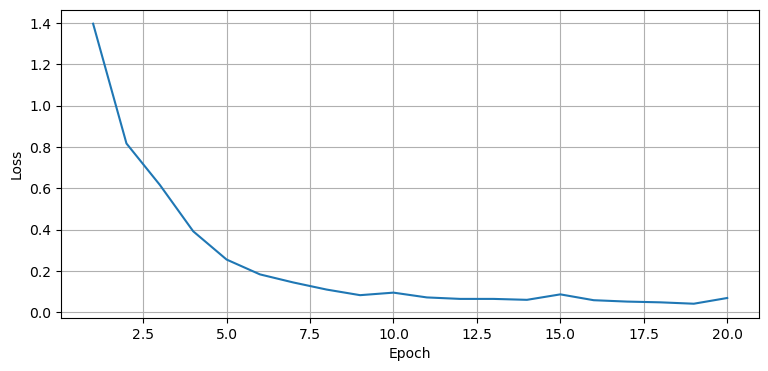

In [101]:
plt.figure(figsize=(9,4))
plt.plot(np.arange(1, 20+1), train_losses_tune)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [103]:
train_predictions, train_labels = predict(model_tune, train_loader_notf, device)
test_predictions, test_labels = predict(model_tune, test_loader, device)

result_summary(train_predictions, train_labels)
print()
result_summary(test_predictions, test_labels)

Accuracy: 0.9867
Confusion Matrix:
[[ 722    1    1    0]
 [   0   49    0    0]
 [   2    0 2564    0]
 [   0    0   64 1717]]

Accuracy: 0.9313
Confusion Matrix:
[[155   0   8   9]
 [  0  14   0   1]
 [  2   0 630   2]
 [  2   0  64 393]]


In [35]:
torch.save(model_tune.state_dict(), "/kaggle/working/tuned_model.pt")

무작위성 때문에 약간의 차이 발생

TODO: Finish proper evaluation and visualation.